In [23]:
# Project: Quantify convergence between Amazon annual and NYT weekly bestsellers (2009–2021), identify drivers, lead–lag, and persistence for actionable insights.
# Part 0: Load both datasets, standardize columns and types, and build a shared match key for reliable linking.
# Part 1: Identify overlapping books and build a merged table aligned by title–author and year.
# Part 2: Compute yearly overlap counts and rates to track convergence over time.
# Part 3: Compare genre distributions and overlap rates to find which genres converge most.
# Part 4: Contrast ratings, reviews, and prices for Amazon-only vs dual-listed books to assess performance differences.
# Part 5: Relate NYT rank to Amazon metrics to test whether Amazon popularity predicts NYT position.
# Part 6: Measure first-appearance gaps to determine which list leads and by how much.
# Part 7: Link NYT weeks-on-list with Amazon metrics to see if sustained presence aligns with engagement.
# Part 8: Evaluate NYT rank and persistence by price bands to test pricing correlations.
# Part 9: Detect multi-year Amazon bestsellers to quantify persistence that may drive convergence.
# Part 10: Compare top authors and author overlap to understand creator-level drivers.
# Part 11: Visualize core findings to make convergence patterns clear.
# Part 13: Plot author leaderboards to highlight shared and divergent dominance.  
# Part 14: Export key result tables for grading, replication, and reporting.
# Part 15: Print a concise summary of convergence levels, peaks and lows, genre effects, timing, and persistence.

In [18]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore")

AMAZON_FILE = r"C:\Users\32697\Downloads\Amazon_top100_bestselling_books_2009to2021.xlsx"
NYT_FILE    = r"C:\Users\32697\Downloads\bestsellers.csv"

def load_any(p):
    return pd.read_excel(p, engine="openpyxl") if str(p).lower().endswith((".xlsx",".xls")) else pd.read_csv(p)

def canonicalize_columns(df, aliases):
    df.columns = [c.strip() for c in df.columns]
    low = {c.lower(): c for c in df.columns}
    rename, missing = {}, []
    for canon, cands in aliases.items():
        hit = next((low[a.lower()] for a in cands if a.lower() in low), None)
        if hit: rename[hit] = canon
        else: missing.append(canon)
    if missing: raise KeyError(f"Missing expected columns: {missing}. Have: {list(df.columns)}")
    df.rename(columns=rename, inplace=True)
    return df

amazon_aliases = {
    "Name":        ["Name","Title","Book","Book Title","title"],
    "Author":      ["Author","Authors","author","authors"],
    "Genre":       ["Genre","Category","Type","genre","category"],
    "User Rating": ["User Rating","user_rating","Rating","Avg Rating","ratings"],
    "Reviews":     ["Reviews","Review Count","Num_Reviews","Number of Reviews","no_of_reviews"],
    "Price":       ["Price","List Price","list_price","price"],
    "Year":        ["Year","Publication Year","Pub Year","pub_year","year"]
}
nyt_aliases = {
    "title":          ["title","Title","Book","Name"],
    "author":         ["author","Author","Authors"],
    "published_date": ["published_date","date","pub_date","Publication Date"],
    "rank":           ["rank","best_sellers_rank","Best Rank"],
    "weeks_on_list":  ["weeks_on_list","weeks","Weeks on List"]
}

df_amazon = canonicalize_columns(load_any(AMAZON_FILE), amazon_aliases)
df_nyt    = canonicalize_columns(load_any(NYT_FILE), nyt_aliases)

df_amazon = df_amazon.loc[:, ~df_amazon.columns.str.match(r"Unnamed", na=False)]

df_amazon["User Rating"] = pd.to_numeric(df_amazon["User Rating"], errors="coerce")
df_amazon["Reviews"]     = pd.to_numeric(df_amazon["Reviews"], errors="coerce")
df_amazon["Price"]       = pd.to_numeric(df_amazon["Price"], errors="coerce")
df_amazon["Year"]        = pd.to_numeric(df_amazon["Year"], errors="coerce").astype("Int64")

df_nyt["published_date"] = pd.to_datetime(df_nyt["published_date"], errors="coerce")
df_nyt["year"] = df_nyt["published_date"].dt.year

df_amazon["match_key"] = df_amazon["Name"].astype(str).str.lower().str.strip() + "|" + df_amazon["Author"].astype(str).str.lower().str.strip()
df_nyt["match_key"]    = df_nyt["title"].astype(str).str.lower().str.strip()   + "|" + df_nyt["author"].astype(str).str.lower().str.strip()

print(df_amazon.shape, df_nyt.shape)


(1291, 10) (61430, 14)


In [3]:
amazon_books = set(df_amazon["match_key"].dropna().unique())
nyt_books = set(df_nyt["match_key"].dropna().unique())
overlap_books = amazon_books & nyt_books
overlap_rate = 100 * len(overlap_books) / len(amazon_books) if amazon_books else 0.0

df_amazon["in_nyt"] = df_amazon["match_key"].isin(overlap_books)

nyt_aggregated = (
    df_nyt.groupby(["match_key","year"], dropna=False)
          .agg(rank=("rank","min"), weeks_on_list=("weeks_on_list","max"))
          .reset_index()
)

df_overlap = (
    df_amazon[df_amazon["match_key"].isin(overlap_books)]
    .merge(nyt_aggregated, left_on=["match_key","Year"], right_on=["match_key","year"], how="left")
)

print(len(amazon_books), len(nyt_books), len(overlap_books), f"{overlap_rate:.1f}%")
df_overlap.head(3)


747 6668 93 12.4%


,Price,ranks,Name,Reviews,User Rating,Author,cover_type,Year,Genre,match_key,in_nyt,year,rank,weeks_on_list
0,12.49,1.0,The Lost Symbol,16118.0,4.4,Dan Brown,Hardcover,2009,Fiction,the lost symbol|dan brown,True,NaN,NaN,NaN
1,12.66,7.0,The Help,18068.0,4.8,Kathryn Stockett,Hardcover,2009,Fiction,the help|kathryn stockett,True,NaN,NaN,NaN
2,8.77,33.0,Olive Kitteridge,11519.0,4.3,Elizabeth Strout,Paperback,2009,Fiction,olive kitteridge|elizabeth strout,True,NaN,NaN,NaN


In [4]:
years = sorted(df_amazon["Year"].dropna().astype(int).unique())
yearly = []
for y in years:
    az = set(df_amazon.loc[df_amazon["Year"]==y, "match_key"].dropna().unique())
    ny = set(df_nyt.loc[df_nyt["year"]==y, "match_key"].dropna().unique())
    inter = len(az & ny)
    rate = 100*inter/len(az) if az else 0.0
    yearly.append({"year": y, "amazon_count": len(az), "nyt_count": len(ny), "overlap_count": inter, "overlap_rate": rate})
df_yearly = pd.DataFrame(yearly).sort_values("year").reset_index(drop=True)
print(df_yearly.head(3).to_string(index=False))
print("mean_overlap_rate:", round(df_yearly["overlap_rate"].mean(),1))
print("max:", df_yearly.loc[df_yearly["overlap_rate"].idxmax(), ["year","overlap_rate"]].to_dict())
print("min:", df_yearly.loc[df_yearly["overlap_rate"].idxmin(), ["year","overlap_rate"]].to_dict())


 year  amazon_count  nyt_count  overlap_count  overlap_rate
 2009            97          0              0      0.000000
 2010            97        728             13     13.402062
 2011            97        871             13     13.402062
mean_overlap_rate: 9.6
max: {'year': 2017.0, 'overlap_rate': 16.0}
min: {'year': 2009.0, 'overlap_rate': 0.0}


In [5]:
genre_counts = df_amazon["Genre"].value_counts()

genre_stats = (
    df_amazon.groupby("Genre", dropna=False)
             .agg(**{
                 "Avg Rating":("User Rating","mean"),
                 "Avg Reviews":("Reviews","mean"),
                 "Avg Price":("Price","mean"),
                 "Count":("Name","count")
             })
             .round(2)
)

overlap_by_genre = df_overlap.groupby("Genre", dropna=False).size()
total_by_genre = df_amazon.groupby("Genre", dropna=False).size()
genre_overlap_rate = ((overlap_by_genre/total_by_genre)*100).round(1)

print("genres:", len(genre_counts))
print(genre_stats.head(3).to_string())
print(genre_overlap_rate.dropna().sort_values(ascending=False).to_string())


genres: 3
             Avg Rating  Avg Reviews  Avg Price  Count
Genre                                                 
Fiction            4.67     33079.28      12.91    560
Non Fiction        4.63     20275.95      14.42    723
unknown            4.63      8738.00      13.02      2
Genre
Fiction        20.1
Non Fiction     5.9


In [6]:
comparison = (
    df_amazon.groupby("in_nyt", dropna=False)
             .agg(**{
                 "User Rating":("User Rating","mean"),
                 "Reviews":("Reviews","mean"),
                 "Price":("Price","mean")
             })
             .round(2)
)
comparison.index = ["Amazon only","Both datasets"] if len(comparison)==2 else comparison.index

amazon_only = df_amazon[~df_amazon["in_nyt"]]
both_sets   = df_amazon[df_amazon["in_nyt"]]

reviews_ratio = np.nan
rating_diff  = np.nan
price_diff   = np.nan
if len(amazon_only) and len(both_sets):
    reviews_ratio = both_sets["Reviews"].mean() / amazon_only["Reviews"].mean()
    rating_diff   = both_sets["User Rating"].mean() - amazon_only["User Rating"].mean()
    price_diff    = both_sets["Price"].mean() - amazon_only["Price"].mean()

print(comparison)
print("reviews_ratio:", None if pd.isna(reviews_ratio) else round(reviews_ratio,2))
print("rating_diff:",  None if pd.isna(rating_diff)  else round(rating_diff,3))
print("price_diff:",   None if pd.isna(price_diff)   else round(price_diff,2))


               User Rating   Reviews  Price
Amazon only           4.65  24270.94  13.80
Both datasets         4.63  37114.30  13.44
reviews_ratio: 1.53
rating_diff: -0.02
price_diff: -0.36


In [7]:
df_analysis = df_overlap[df_overlap["rank"].notna()].copy()
if len(df_analysis):
    correlations = df_analysis[["rank","User Rating","Reviews","Price"]].corr(numeric_only=True)["rank"].drop("rank").round(3)
    top_books = df_analysis.nsmallest(10,"rank")[["Name","Author","Year","rank","User Rating","Price"]]
else:
    correlations = pd.Series(dtype=float)
    top_books = pd.DataFrame(columns=["Name","Author","Year","rank","User Rating","Price"])
print(correlations)
top_books.head(10)


User Rating   -0.170
Reviews       -0.150
Price          0.148
Name: rank, dtype: float64


,Name,Author,Year,rank,User Rating,Price
13,The Help,Kathryn Stockett,2010,1.0,4.8,13.78
17,The Hunger Games,Suzanne Collins,2010,1.0,4.7,22.60
18,Freedom,Jonathan Franzen,2010,1.0,4.0,17.48
19,Chelsea Chelsea Bang Bang,Chelsea Handler,2010,1.0,4.4,9.65
21,The Overton Window,Glenn Beck,2010,1.0,4.6,15.00
22,Spoken from the Heart,Laura Bush,2010,1.0,4.6,12.60
23,Safe Haven,Nicholas Sparks,2010,1.0,4.7,14.77
25,The Book Thief,Markus Zusak,2010,1.0,4.7,6.99
26,Steve Jobs,Walter Isaacson,2011,1.0,4.7,17.33
27,The Help,Kathryn Stockett,2011,1.0,4.8,9.98


In [8]:
timing = []
for mk in overlap_books:
    a_years = df_amazon.loc[df_amazon["match_key"]==mk, "Year"].dropna().astype(int).values
    n_years = df_nyt.loc[df_nyt["match_key"]==mk, "year"].dropna().astype(int).values
    if a_years.size and n_years.size:
        a_first = a_years.min()
        n_first = n_years.min()
        timing.append({
            "book": mk.split("|")[0],
            "amazon_first": int(a_first),
            "nyt_first": int(n_first),
            "lag": int(a_first - n_first)
        })
df_timing = pd.DataFrame(timing)
same_year   = int((df_timing["lag"]==0).sum()) if len(df_timing) else 0
nyt_earlier = int((df_timing["lag"]<0).sum())  if len(df_timing) else 0
amz_earlier = int((df_timing["lag"]>0).sum())  if len(df_timing) else 0
print(len(df_timing), "books")
print("same_year:", same_year, "nyt_earlier:", nyt_earlier, "amazon_earlier:", amz_earlier)
df_timing.head(10)


93 books
same_year: 61 nyt_earlier: 15 amazon_earlier: 17


,book,amazon_first,nyt_first,lag
0,the one and only ivan,2013,2013,0
1,"the boy, the mole, the fox and the horse",2020,2019,1
2,"autobiography of mark twain, vol. 1",2010,2010,0
3,looking for alaska,2013,2012,1
4,thirteen reasons why,2017,2010,7
5,so you want to talk about race,2020,2019,1
6,the hate u give,2018,2017,1
7,watchmen,2009,2019,-10
8,spoken from the heart,2010,2010,0
9,humans of new york,2013,2013,0


In [9]:
nyt_weeks = (
    df_nyt.groupby("match_key", dropna=False)
          .agg(weeks_on_list=("weeks_on_list","max"), rank=("rank","min"), year=("year","first"))
          .reset_index()
)
df_merged = df_amazon.merge(nyt_weeks, on="match_key", how="inner")
weeks_corrs = (
    df_merged[["weeks_on_list","User Rating","Reviews","Price"]]
    .corr(numeric_only=True)["weeks_on_list"]
    .drop("weeks_on_list")
    .round(3)
    if len(df_merged) else pd.Series(dtype=float)
)
print(len(df_merged), "books with weeks_on_list")
print(weeks_corrs)


156 books with weeks_on_list
User Rating    0.298
Reviews       -0.061
Price         -0.124
Name: weeks_on_list, dtype: float64


In [10]:
df_merged["price_range"] = pd.cut(
    df_merged["Price"],
    bins=[0,10,15,20,1e9],
    labels=["$0-10","$10-15","$15-20","$20+"],
    include_lowest=True
)
price_rank = (
    df_merged.groupby("price_range", observed=True)
             .agg(rank=("rank","mean"),
                  weeks_on_list=("weeks_on_list","mean"),
                  User_Rating=("User Rating","mean"),
                  Reviews=("Reviews","mean"))
             .round(2)
)
best_price_range = price_rank["rank"].idxmin() if len(price_rank) else None
print(price_rank)
print("best_price_range:", best_price_range)


             rank  weeks_on_list  User_Rating   Reviews
price_range                                            
$0-10        1.37         161.47         4.70  28446.63
$10-15       1.32          73.71         4.62  50943.90
$15-20       1.24          40.55         4.56  32389.59
$20+         1.88         175.00         4.62  18632.88
best_price_range: $15-20


In [11]:
multi_year = (
    df_amazon.groupby("match_key", dropna=False)
             .agg(Year=("Year", lambda x: list(pd.Series(x).dropna().astype(int))),
                  Name=("Name","first"),
                  Author=("Author","first"),
                  Genre=("Genre","first"),
                  User_Rating=("User Rating","mean"),
                  Reviews=("Reviews","mean"))
             .reset_index(drop=True)
)
multi_year["years_count"] = multi_year["Year"].apply(len)
multi_year_books = multi_year[multi_year["years_count"]>1].sort_values("years_count", ascending=False)
multi_year_books.head(10)[["Name","Author","years_count","User_Rating","Reviews"]]


,Name,Author,years_count,User_Rating,Reviews
476,The 5 Love Languages: The Secret to Love That ...,Gary Chapman,12,4.758333,43676.833333
409,Publication Manual of the American Psychologic...,American Psychological Association,11,4.500000,12674.000000
462,StrengthsFinder 2.0,Gallup,11,4.100000,7082.000000
478,The 7 Habits of Highly Effective People: Power...,Stephen R. Covey,10,4.650000,5431.500000
524,The Four Agreements: A Practical Guide to Pers...,Don Miguel Ruiz,10,4.700000,86676.000000
722,What to Expect When You're Expecting,Heidi Murkoff,9,4.800000,29389.000000
597,The Official SAT Study Guide,The College Board,9,4.422222,1708.000000
543,The Great Gatsby: The Only Authorized Edition,F. Scott Fitzgerald,9,4.500000,18656.000000
329,Love You Forever,Robert Munsch,9,4.900000,53161.000000
261,How to Win Friends & Influence People,Dale Carnegie,9,4.700000,79094.000000


In [12]:
top_amazon_authors = df_amazon["Author"].value_counts().head(10)
top_nyt_authors = df_nyt["author"].value_counts().head(10)
amazon_authors = set(df_amazon["Author"].astype(str).str.lower().unique())
nyt_authors = set(df_nyt["author"].astype(str).str.lower().unique())
common_authors = amazon_authors & nyt_authors
print("common_authors:", len(common_authors))
top_amazon_authors, top_nyt_authors


common_authors: 260


(Author
 Rick Riordan                          20
 Suzanne Collins                       17
 Jeff Kinney                           17
 John Grisham                          15
 Gallup                                13
 American Psychological Association    13
 Gary Chapman                          13
 Dr. Seuss                             13
 Malcolm Gladwell                      12
 Bill Martin Jr.                       12
 Name: count, dtype: int64,
 author
 Bill O'Reilly and Martin Dugard    741
 Laura Hillenbrand                  662
 Malcolm Gladwell                   624
 E L James                          620
 Rick Riordan                       610
 John Grisham                       563
 John Green                         511
 RJ Palacio                         479
 Jeff Kinney                        471
 Gary Chapman                       466
 Name: count, dtype: int64)

'saved complete_analysis_main.png'

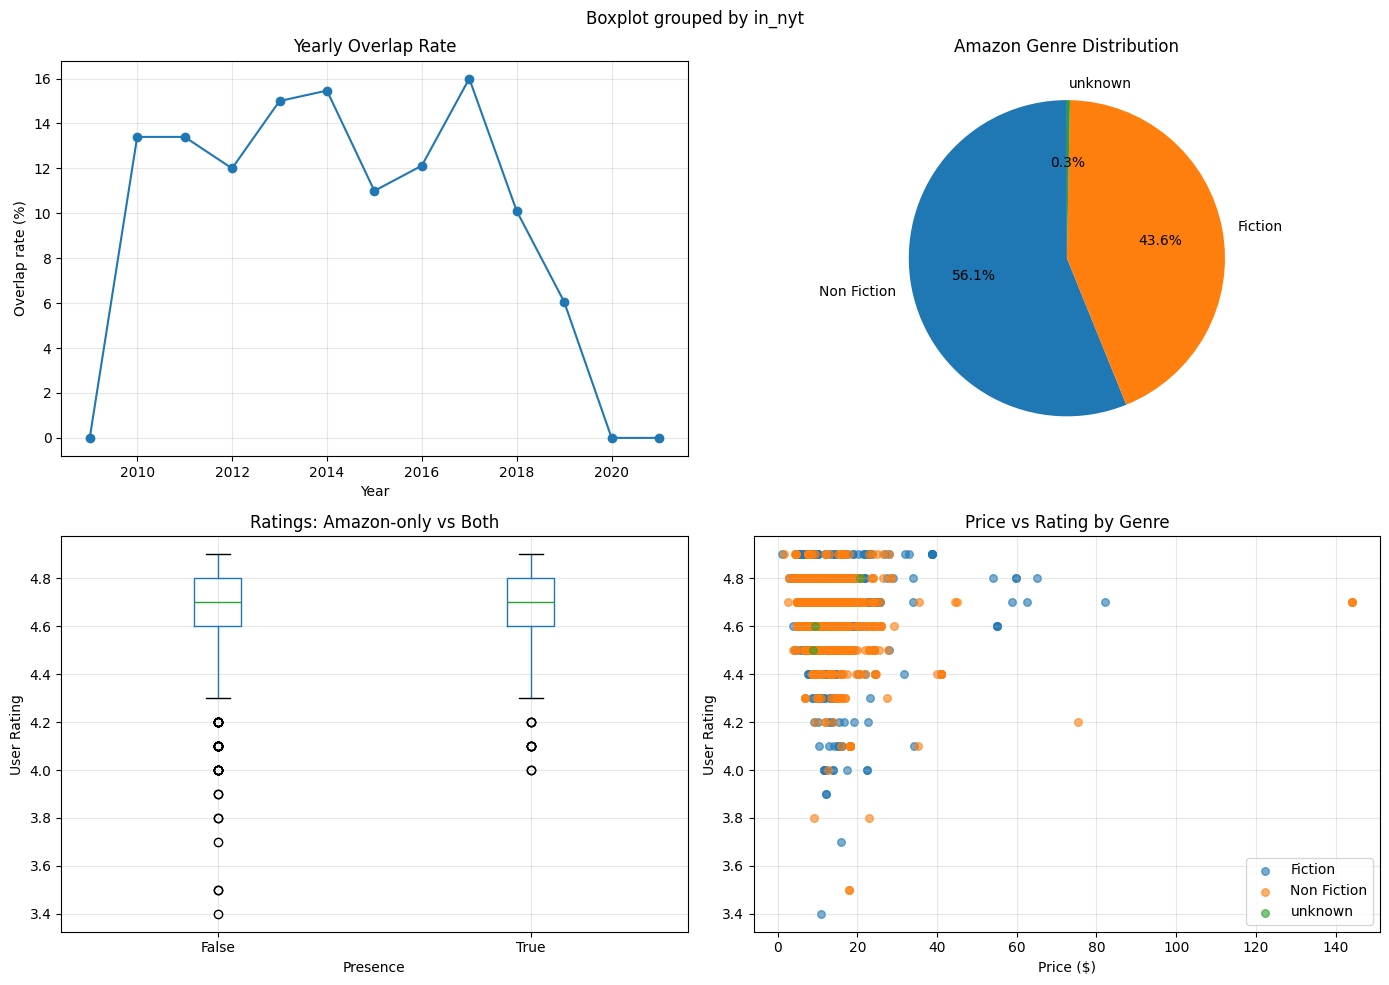

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = 10

fig, axes = plt.subplots(2,2)
fig.suptitle("Amazon vs NYT Bestsellers Analysis (2009–2019)")

axes[0,0].plot(df_yearly["year"], df_yearly["overlap_rate"], marker="o")
axes[0,0].set_xlabel("Year")
axes[0,0].set_ylabel("Overlap rate (%)")
axes[0,0].set_title("Yearly Overlap Rate")
axes[0,0].grid(True, alpha=0.3)

axes[0,1].pie(genre_counts.values, labels=genre_counts.index, autopct="%1.1f%%", startangle=90)
axes[0,1].set_title("Amazon Genre Distribution")

df_amazon.boxplot(column="User Rating", by="in_nyt", ax=axes[1,0])
axes[1,0].set_xlabel("Presence")
axes[1,0].set_ylabel("User Rating")
axes[1,0].set_title("Ratings: Amazon-only vs Both")
axes[1,0].grid(True, alpha=0.3)

for g in df_amazon["Genre"].dropna().unique():
    d = df_amazon[df_amazon["Genre"]==g]
    axes[1,1].scatter(d["Price"], d["User Rating"], alpha=0.6, s=30, label=g)
axes[1,1].set_xlabel("Price ($)")
axes[1,1].set_ylabel("User Rating")
axes[1,1].set_title("Price vs Rating by Genre")
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("complete_analysis_main.png", dpi=300, bbox_inches="tight")
"saved complete_analysis_main.png"


'saved complete_analysis_authors.png'

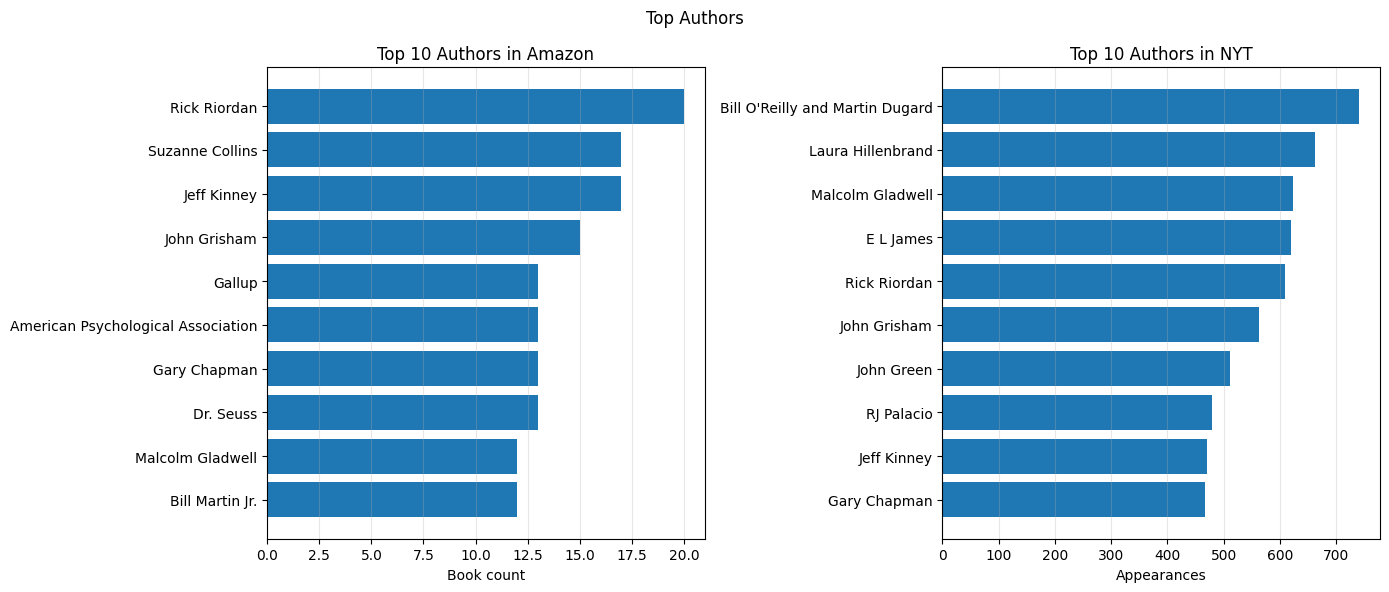

In [15]:
fig3, axes3 = plt.subplots(1,2, figsize=(14,6))
fig3.suptitle("Top Authors")
axes3[0].barh(range(len(top_amazon_authors)), top_amazon_authors.values)
axes3[0].set_yticks(range(len(top_amazon_authors)))
axes3[0].set_yticklabels(top_amazon_authors.index)
axes3[0].invert_yaxis()
axes3[0].set_xlabel("Book count")
axes3[0].set_title("Top 10 Authors in Amazon")
axes3[0].grid(True, axis="x", alpha=0.3)

axes3[1].barh(range(len(top_nyt_authors)), top_nyt_authors.values)
axes3[1].set_yticks(range(len(top_nyt_authors)))
axes3[1].set_yticklabels(top_nyt_authors.index)
axes3[1].invert_yaxis()
axes3[1].set_xlabel("Appearances")
axes3[1].set_title("Top 10 Authors in NYT")
axes3[1].grid(True, axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("complete_analysis_authors.png", dpi=300, bbox_inches="tight")
"saved complete_analysis_authors.png"


In [16]:
overlap_export = (
    df_overlap[["Name","Author","Genre","Year","User Rating","Reviews","Price","rank","weeks_on_list"]]
    .sort_values("weeks_on_list", ascending=False, na_position="last")
)
overlap_export.to_csv("complete_overlap_details.csv", index=False)

df_timing.to_csv("complete_timing_analysis.csv", index=False)
df_yearly.to_csv("complete_yearly_stats.csv", index=False)
genre_stats.to_csv("complete_genre_stats.csv")

["complete_overlap_details.csv","complete_timing_analysis.csv","complete_yearly_stats.csv","complete_genre_stats.csv"]


['complete_overlap_details.csv',
 'complete_timing_analysis.csv',
 'complete_yearly_stats.csv',
 'complete_genre_stats.csv']

In [17]:
import numpy as np, pandas as pd

def _yr_range(s):
    y = pd.to_numeric(s, errors="coerce").dropna().astype(int)
    return (int(y.min()), int(y.max())) if len(y) else (None, None)

a_min, a_max = _yr_range(df_amazon["Year"])
n_min, n_max = _yr_range(df_nyt["year"])

print("Amazon rows:", len(df_amazon), f"{a_min}–{a_max}")
print("NYT unique books:", df_nyt["match_key"].nunique(), f"{n_min}–{n_max}")
print("Books in both:", len(overlap_books), f"Overlap rate: {overlap_rate:.1f}%")

if "df_yearly" in globals() and len(df_yearly):
    mean_rate = round(df_yearly["overlap_rate"].mean(), 1)
    y_max = int(df_yearly.loc[df_yearly["overlap_rate"].idxmax(), "year"])
    r_max = float(df_yearly["overlap_rate"].max())
    y_min = int(df_yearly.loc[df_yearly["overlap_rate"].idxmin(), "year"])
    r_min = float(df_yearly["overlap_rate"].min())
    print("Mean yearly overlap:", mean_rate)
    print("Peak year:", y_max, f"{r_max:.1f}%")
    print("Lowest year:", y_min, f"{r_min:.1f}%")

fic = genre_overlap_rate.get("Fiction", np.nan) if "genre_overlap_rate" in globals() else np.nan
nonfic = genre_overlap_rate.get("Non Fiction", np.nan) if "genre_overlap_rate" in globals() else np.nan
print("Fiction overlap:", None if pd.isna(fic) else float(fic))
print("Non Fiction overlap:", None if pd.isna(nonfic) else float(nonfic))

if "reviews_ratio" in globals() and not pd.isna(reviews_ratio):
    print("Reviews ratio (both/Amazon-only):", round(float(reviews_ratio), 2))
if "rating_diff" in globals() and not pd.isna(rating_diff):
    print("Rating diff:", round(float(rating_diff), 3))
if "price_diff" in globals() and not pd.isna(price_diff):
    print("Price diff:", round(float(price_diff), 2))

if "df_timing" in globals() and len(df_timing):
    same_year = int((df_timing["lag"]==0).sum())
    nyt_earlier = int((df_timing["lag"]<0).sum())
    amz_earlier = int((df_timing["lag"]>0).sum())
    print("Same year:", same_year, "NYT earlier:", nyt_earlier, "Amazon earlier:", amz_earlier)

if "df_merged" in globals() and len(df_merged):
    print("Mean NYT weeks:", round(df_merged["weeks_on_list"].mean(), 1))
    if "weeks_corrs" in globals() and len(weeks_corrs):
        print("Weeks corr with rating:", round(float(weeks_corrs.get("User Rating", np.nan)), 3))
        print("Weeks corr with reviews:", round(float(weeks_corrs.get("Reviews", np.nan)), 3))
    if "best_price_range" in globals():
        print("Best price range:", best_price_range)

print("Common authors:", len(common_authors))


Amazon rows: 1291 2009–2021
NYT unique books: 6668 2010–2019
Books in both: 93 Overlap rate: 12.4%
Mean yearly overlap: 9.6
Peak year: 2017 16.0%
Lowest year: 2009 0.0%
Fiction overlap: 20.1
Non Fiction overlap: 5.9
Reviews ratio (both/Amazon-only): 1.53
Rating diff: -0.02
Price diff: -0.36
Same year: 61 NYT earlier: 15 Amazon earlier: 17
Mean NYT weeks: 105.5
Weeks corr with rating: 0.298
Weeks corr with reviews: -0.061
Best price range: $15-20
Common authors: 260
